### Реальные и модельные данные

Будет рассмотрена выборка ирисов Фишера по двум признакам petalLength и petalWidth.

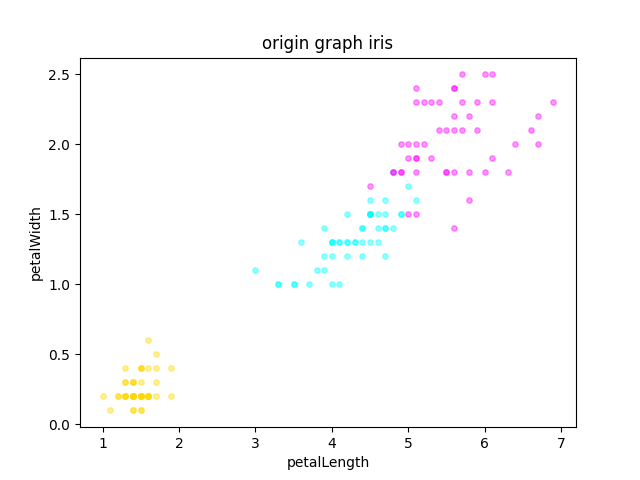

Также будет использованно несколько модельных выборок:


*   Выборка с двумя классами, которые полученны из множества распределений. Один из классов почти вложен в другой. Выборка "эллипсов".
*   Выборка, где классы состоят из данных, полученных из разных распределений, но при этом один из них немного "накладывается" на другой. Выборка "параболы".
*   Выборка, где 2 класса, состоящих из 2 групп объектов, сформированных разными распределениями лежат крест-накрест. Выборка "гиперболы".


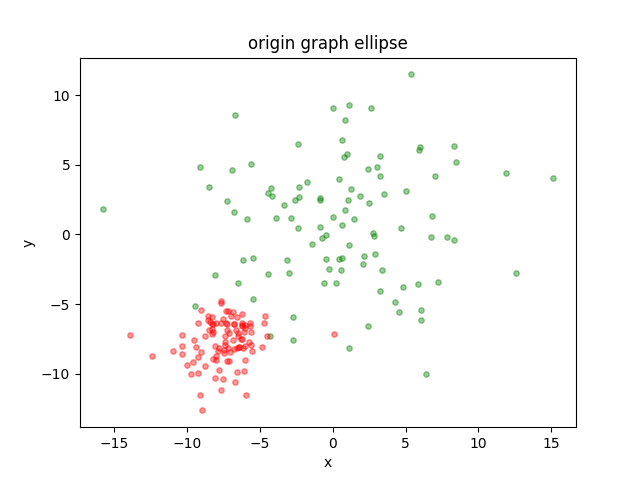

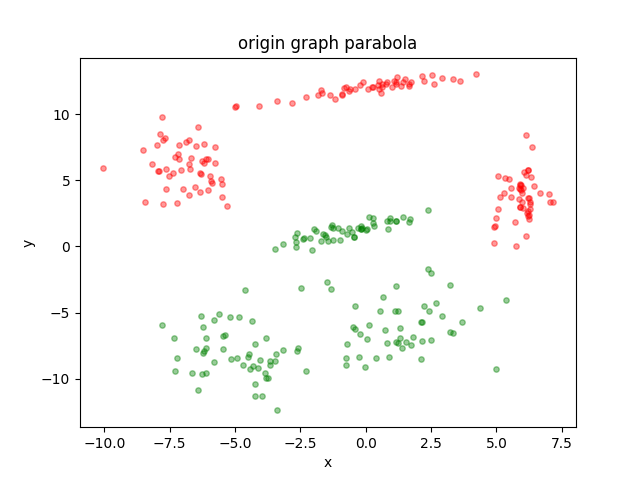

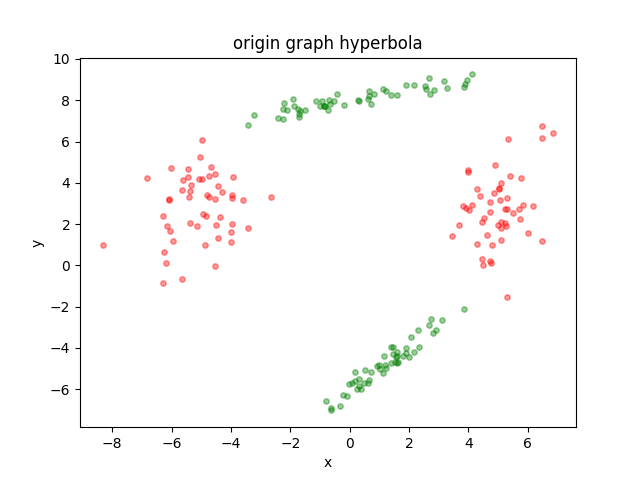

### Описание алгоритма

Суть подстановочного метода и его отличие от наивного байесовского классификатора заключается в том, что для каждого класса выделяется своя n-мерная нормальная плотность распределения:

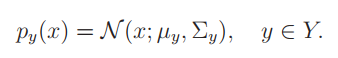

С таким условием байесовский классификатор задает квадратичную разделяющую поверхность между классами (гипербола, парабола, эллипс). Если же ковариационные матрицы классов равны, как в случае с линейным дискриминантом фишера, то разделяющая поверхность линейна.

Задав потери классификации и рассчитав априорные вероятности классов можно составить оптимальное байесовское решающее правило:

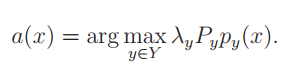

Оптимальные оценки вычисляются по формулам:

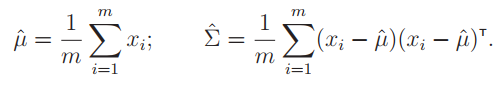

Поверхности 2 порядка получаются на кривых пересечений нормальных распределений для 2 координат. 

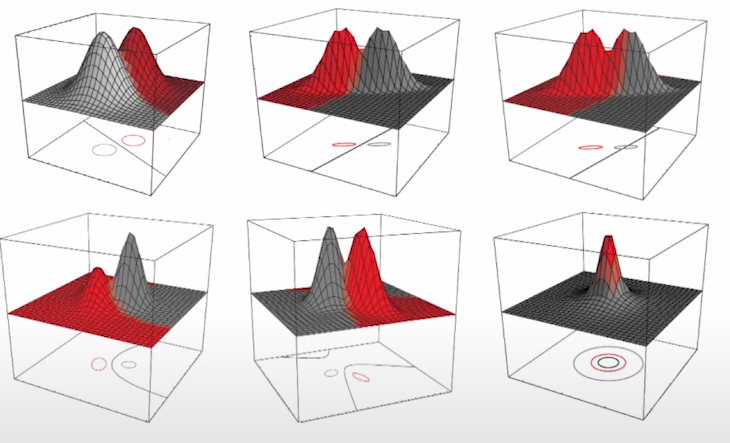

### Код программы

Класс, реализующий подстановочный метод наследуется от абстрактного, дискриминантного класса.

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd


class AbstractDisc(ABC):
    _objects: list
    _answers: list
    answer_set: list

    cases_count: int
    component_count: int

    classes_errors: dict
    cases_by_classes: dict
    classes_probabilities: dict

    centers: dict
    covariance: dict

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, cl_errors: dict = None, is_column_name=True):
        if is_column_name:
            objects.columns = objects.iloc[0]
            answers.columns = answers.iloc[0]
        self.objects = objects
        self.answers = answers
        if cl_errors is None:
            self.classes_errors = dict()
            for y in self.answer_set:
                self.classes_errors[y] = 1
        self.component_count = len(self.objects[0][1])
        self.cases_count = len(self.objects)
        self.cases_by_classes_init()
        self.classes_probabilities_init()

    @property
    def objects(self):
        return self._objects

    @objects.setter
    def objects(self, val):
        self._objects = []
        for index, obj in val.iterrows():
            self._objects.append((index, np.array(obj)))

    @property
    def answers(self):
        return self._answers

    @answers.setter
    def answers(self, val):
        self._answers = []
        for _, answer in val.iterrows():
            self._answers.append(answer.tolist()[0])
        # Формирование упорядоченого множества
        self.answer_set = list(dict.fromkeys(self._answers))

    def cases_by_classes_init(self):
        self.cases_by_classes = dict.fromkeys(self.answer_set)

        for key in self.cases_by_classes:
            self.cases_by_classes[key] = dict()

        for x in self.objects:
            y = self.answers[x[0]]
            self.cases_by_classes[y][x[0]] = x

    def classes_probabilities_init(self):
        self.classes_probabilities = dict()
        for y in self.answer_set:
            self.classes_probabilities[y] = float(len(self.cases_by_classes[y])) / self.cases_count

    @abstractmethod
    def centers_init(self, *args):
        pass

    @abstractmethod
    def covariance_init(self, *args):
        pass

    @abstractmethod
    def gamma(self, x, y):
        pass

    def classify(self, x, is_new_element=True, *args):
        if not is_new_element:
            x = x[1]

        max_gamma = None
        arg_max = None
        for y in self.answer_set:
            gamma = self.gamma(x, y)
            if max_gamma is None or gamma > max_gamma:
                max_gamma = gamma
                arg_max = y
        return arg_max
  
    def error(self):
        incorrect_object_answer = 0
        for x in self.objects:
            a = self.classify(x, False)
            if a != self.answers[x[0]]:
                incorrect_object_answer += 1
        return incorrect_object_answer / self.cases_count

Реализация нормального Plug-in метода.

In [ ]:
import numpy as np
import pandas as pd
import nd_normal_distribution as ndn
import abstract_disc_class as abs_dc


class NormalPlugIn(abs_dc.AbstractDisc):
    normal_dist_by_classes: dict

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, draw_step=0.2, draw_size=1.5,
                 cl_errors: dict = None, is_column_name=True):
        super().__init__(objects, answers, cl_errors, is_column_name)
        self.centers_init()
        self.covariance_init()
        self.normal_dist_by_classes_init(draw_step, draw_size)

    def centers_init(self):
        self.centers = dict()
        for y in self.answer_set:
            self.centers[y] = []

        for y in self.answer_set:
            res = np.zeros(self.component_count)
            m = self.cases_by_classes[y].keys()
            for i in m:
                x = self.cases_by_classes[y][i][1]
                res += x
            self.centers[y] = res / len(m)

    def covariance_init(self):
        self.covariance = dict()
        for y in self.answer_set:
            self.covariance[y] = []

        for y in self.answer_set:
            res = np.zeros((self.component_count, self.component_count))
            m = self.cases_by_classes[y].keys()
            for i in m:
                x = self.cases_by_classes[y][i][1] - self.centers[y]
                res += np.outer(x, x)
            self.covariance[y] = res / (self.cases_count - len(self.answer_set))

    def normal_dist_by_classes_init(self, draw_step, draw_size):
        self.normal_dist_by_classes = dict()
        for y in self.answer_set:
            self.normal_dist_by_classes[y] = \
                ndn.NDimensionalNormalDistribution(self.covariance[y], self.centers[y], draw_size, draw_step)

    def gamma(self, x, y):
        return self.classes_errors[y] * self.classes_probabilities[y] * self.normal_dist_by_classes[y].probability(*x)

### Результаты

Для ирисов Фишера полученна карта классификации:

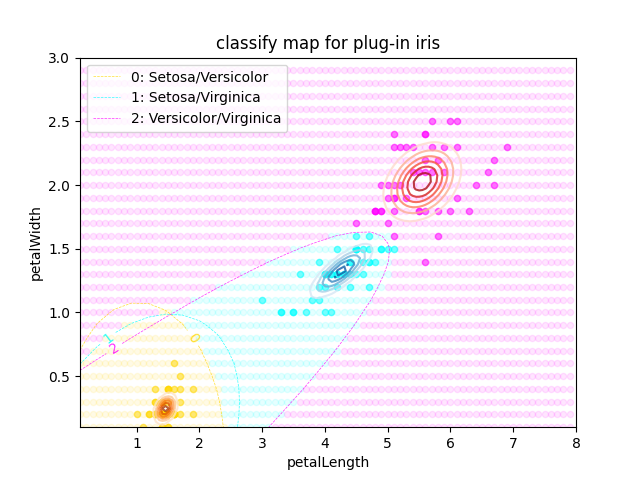

Ошибка равна 1/30, что является лучшим результатом из всех предыдущих рассмотренных методов наравне с базовым методом k соседей.

Для выборки эллипсов получили такую карту классификации:

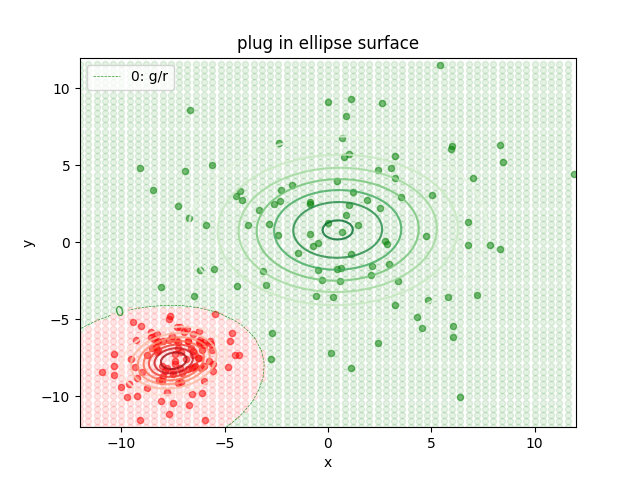

Видно, что красная выборка отделена от зеленой разделяющей поверхностью в виде эллипса. Ошибка равна 1/40.

Для выборки параболы получили такую карту классификации:

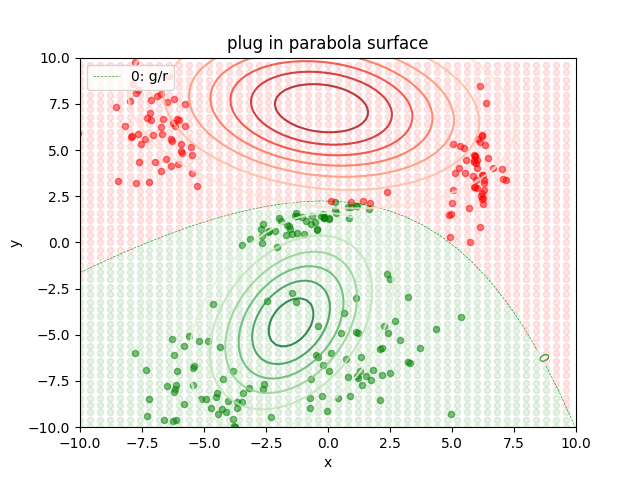

Видно, что зеленый класс отделен от красного гиперболой. Ошибка равна 1/60.



Для выбоки гиперболы получили такую карту классификации:

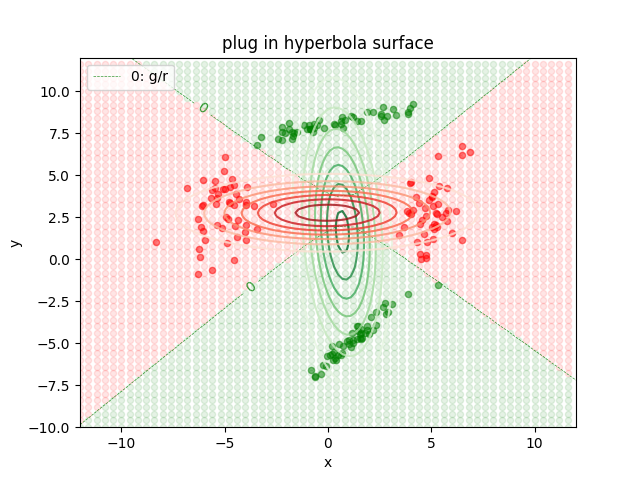

Эти два класса разделены параболой. Ошибка равна 0.005